In [1]:
# import the required libraries
import pickle
import heapq
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop

In [2]:
# Read the dataset
path = 'data.txt'
text = open(path, encoding='utf-8').read().lower()
print('corpus length:', len(text))

corpus length: 600893


In [3]:
# Getting unique word
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 57


In [4]:
# Feature Engineering
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 200285


In [5]:
# Storing features and labels
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [6]:
sentences[100]

've been unskilled and unseemly methods f'

In [7]:
next_chars[100]

'o'

In [8]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [9]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [10]:
X.shape

(200285, 40, 57)

In [11]:
y.shape

(200285, 57)

In [12]:
# Building our model
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [13]:
# Model training
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
1487/1487 [==============================] - 101s 66ms/step - loss: 1.9920 - accuracy: 0.4186 - val_loss: 1.7016 - val_accuracy: 0.4885
Epoch 2/20
1487/1487 [==============================] - 101s 68ms/step - loss: 1.6350 - accuracy: 0.5142 - val_loss: 1.5902 - val_accuracy: 0.5217
Epoch 3/20
1487/1487 [==============================] - 93s 63ms/step - loss: 1.5417 - accuracy: 0.5396 - val_loss: 1.5553 - val_accuracy: 0.5293
Epoch 4/20
1487/1487 [==============================] - 106s 71ms/step - loss: 1.4912 - accuracy: 0.5529 - val_loss: 1.5154 - val_accuracy: 0.5434
Epoch 5/20
1487/1487 [==============================] - 100s 67ms/step - loss: 1.4568 - accuracy: 0.5620 - val_loss: 1.5084 - val_accuracy: 0.5477
Epoch 6/20
1487/1487 [==============================] - 103s 69ms/step - loss: 1.4321 - accuracy: 0.5690 - val_loss: 1.5045 - val_accuracy: 0.5561
Epoch 7/20
1487/1487 [==============================] - 94s 63ms/step - loss: 1.4137 - accuracy: 0.5728 - val_loss: 1.5

In [14]:
# Saving model
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

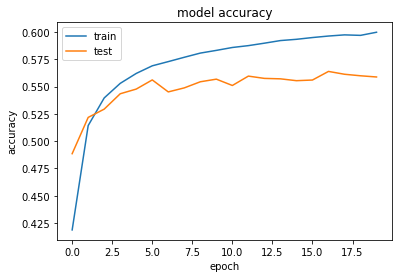

In [15]:
# Evaluating the model
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

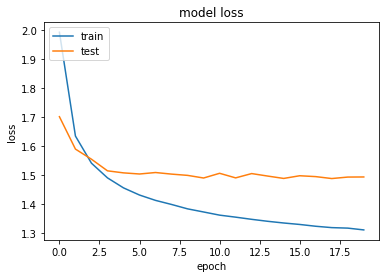

In [17]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [18]:
# Testing next word
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [19]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [20]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [21]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [22]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [23]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [24]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'mankind ', 'a ', 'such ', 'constantial ']

that which does not kill us makes us str
['ong ', 'uct ', 'ength, ', 'ange ', 'ives ']

i'm not upset that you lied to me, i'm u
['nder ', 'pon ', 'sed ', 'tility ', 'deal ']

and those who were seen dancing were tho
['se ', 'ughts ', 'rold ', 'n ', 't ']

it is hard enough to remember my opinion
[' of ', ', ', '\nand ', '.=--the ', 's, ']

